# NYU Talk (Ocean Transport and Eddy Energy CPT)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Latex

$$K_e = K_\rho \frac{(\partial_z C_e)^2}{|\nabla_n C_m|^2}$$

$$\langle u_t C_t \cdot \nabla C_e \rangle = K_\rho(\partial_z C_e)^2$$

$$\langle u_t C_t \cdot \nabla_n C_m \rangle = K_\rho(\partial_z C_m)^2$$

$$(\partial_z C_e)^2 / [(\partial_z C_e)^2 + (\partial_z C_m)^2]$$

In [2]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [39]:
ds_gridded = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_3_z.nc')
ds_gridded_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_rho_binned_high_res.nc').rename({'lon_c':'lon','lat_c':'lat'})

In [4]:
term2_ds_CT = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2_CT = term2_ds_CT.ct_e_z2_filt.rename('term2')
term3_CT = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()

In [7]:
term2_ds_SA = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2_sa.nc').load()
term2_SA = term2_ds_SA.sa_e_z2_filt.rename('term2')
term3_SA = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3_sa.nc').rename('term3').load()

In [5]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

In [6]:
K_e_CT = K_rho*term2_CT/term3_CT

In [8]:
K_e_SA = K_rho*(term2_SA/term3_SA**2)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/1661665281.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title} on density surface: {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


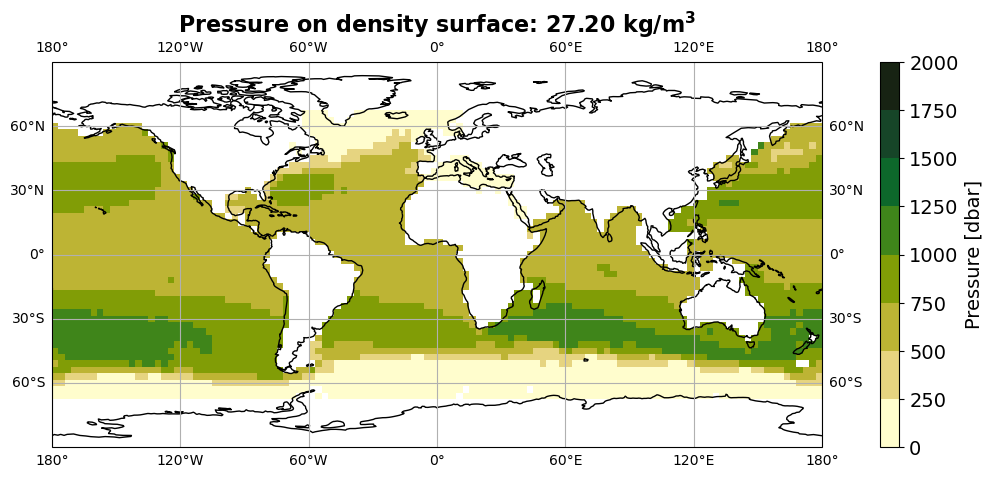

In [89]:
density = 27.2
title= 'Pressure'
units = "dbar"
ds = ds_gridded_rho.PRES.copy(data=ds_gridded_rho.PRES.data)
ds.name = title; ds.attrs["units"] = units
cmap, norm, levels = cmo.speed, colors.Normalize(vmin=0, vmax=2000), np.arange(0, 2001, 250)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, levels=levels)
ax.set_title(f"{title} on density surface: {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/1408466855.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Conservative Temperature'
/tmp/ipykernel_7613/1408466855.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


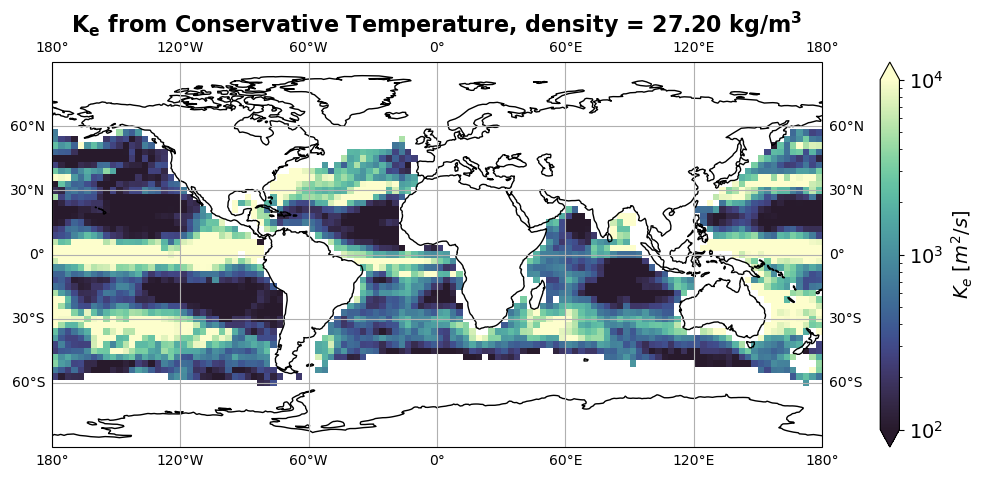

In [90]:
density = 27.2
title = '$\mathbf{{K_e}}$ from Conservative Temperature'
name = '$K_e$'
units = '$m^2/s$'
ds = K_e_CT.copy(data=K_e_CT)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e4)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/3368738509.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Absolute Salinity'
/tmp/ipykernel_7613/3368738509.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


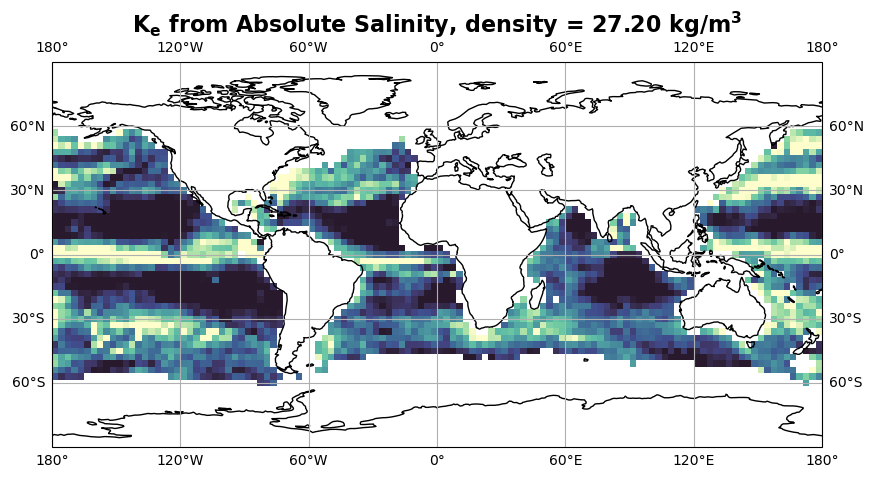

In [91]:
density = 27.2
title = '$\mathbf{{K_e}}$ from Absolute Salinity'
name = '$K_e$'
units = '$m^2/s$'
ds = K_e_SA.copy(data=K_e_SA)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e4)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [83]:
ct_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_meso_VPR.nc')
ct_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_micro_VPR.nc')
ct2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct2_frac.nc')

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/2341952815.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


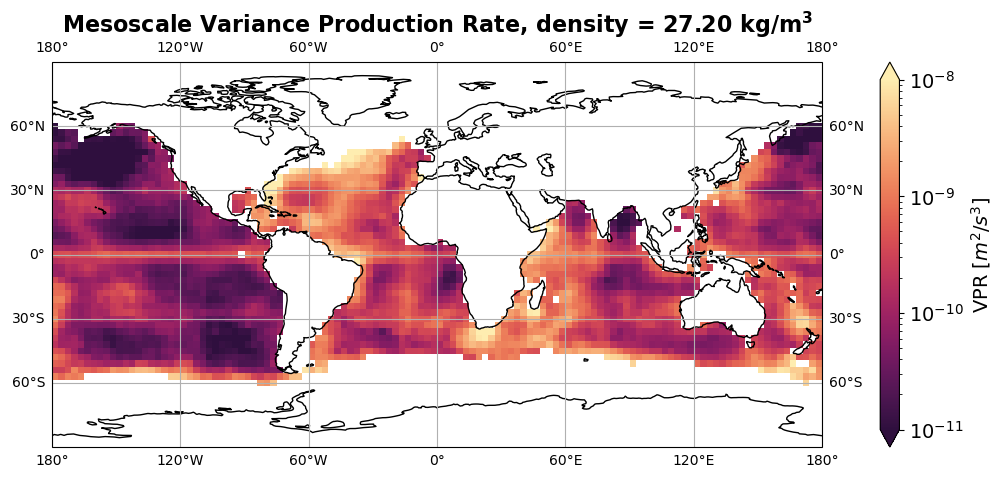

In [94]:
density = 27.2
title = 'Mesoscale Variance Production Rate'
name = 'VPR'
units = '$m^2/s^3$'
ds = ct_meso_VPR.copy(data=ct_meso_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/4050753163.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


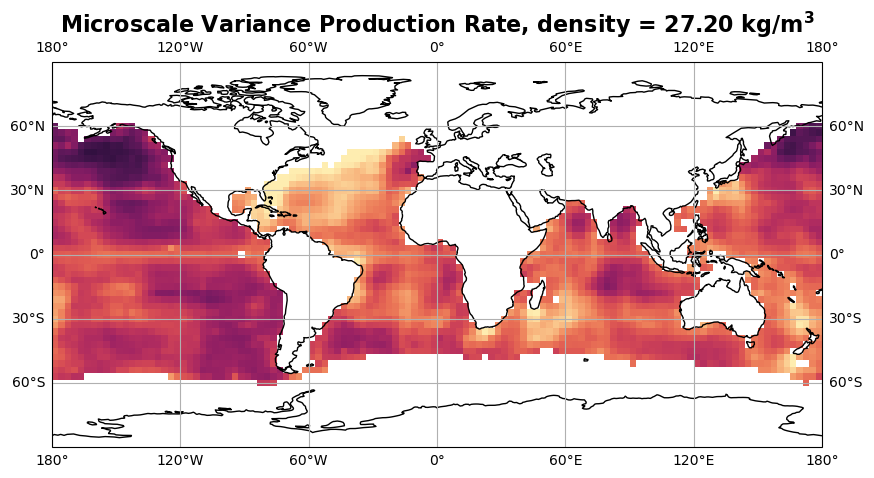

In [93]:
density = 27.2
title = 'Microscale Variance Production Rate'
name = 'Micro VPR'
units = '$m^2/s^3$'
ds = ct_micro_VPR.copy(data=ct_micro_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/2013856225.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


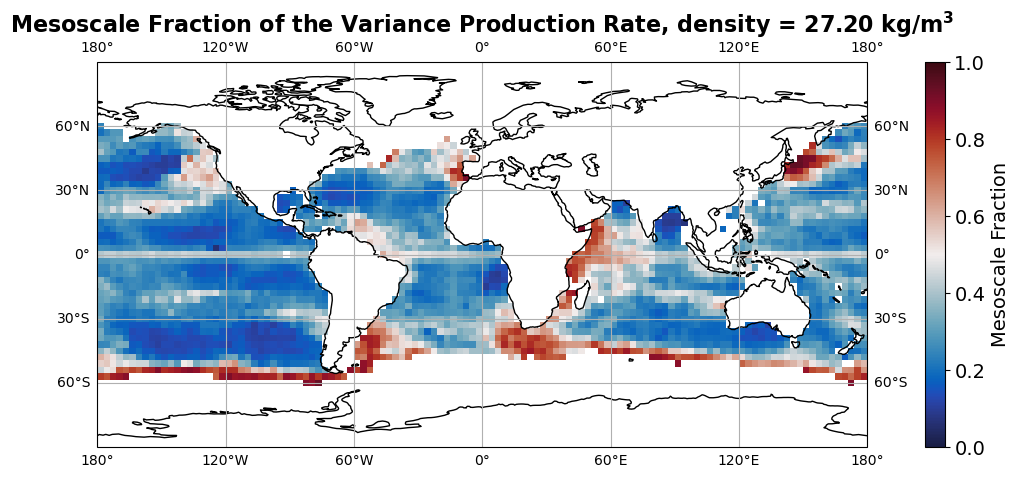

In [92]:
density = 27.2
title = 'Mesoscale Fraction of the Variance Production Rate'
name = 'Mesoscale Fraction'
ds = ct2_frac_VPR.copy(data=ct2_frac_VPR)
ds.name = name
cmap, norm = cmo.balance, colors.Normalize(vmin=0, vmax=1)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");